# load data and do elementary calculations and plots

---

In [1]:
import os
import numpy as np
import dask
import xarray as xr
import xgcm
import cartopy.crs as ccrs
from cmocean import cm
import xscale as xsc
from glob import glob

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.221:8786 Dashboard: http://10.148.0.221:8787/status,Cluster Workers: 10 Cores: 140 Memory: 1000.00 GB


________

# SSU



In [6]:
v = 'SSU'

## open files, nc files
ncdata_dir = '/home1/scratch/xyu/mit_nc/'

# dir where filtered data is stored
out_dir = '/home1/scratch/xyu/mit_filtered/'

In [7]:
face = 5

# search for right files, for example: SSU_f05_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[1:5] # tmp£
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset(scratch+'/mit_grid_t.nc')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 21
Number of files processed: 21
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 5
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [8]:
ds = xr.open_mfdataset(filenames, chunks={'i':432, 'j':432}, concat_dim='time', compat='equals')
ds = ds.assign_coords(time_days=ds['time']/86400.)

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 5040)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 5
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    time_days  (time) float64 66.0 66.04 66.08 66.12 66.17 66.21 66.25 66.29 ...
Data variables:
    SSU        (i, j, time) float32 dask.array<shape=(4320, 4320, 5040), chunksize=(432, 432, 240)>

 data size: 376.2 GB


________
# Temporal filtering (1D along time Dimensions) 

# One point

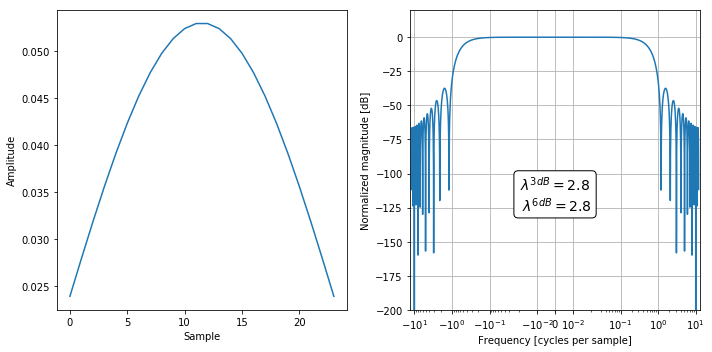

In [9]:
lds = ds.isel(i=0, j=0)

wt = lds['SSU'].window

cutoff = 1.5 # A 1.5-day cutoff
dx = 1./24. # Define the sampling period (one day)
wt.set(n=24*1, dim='time', cutoff=cutoff, dx=dx, window='boxcar')
wt.plot()

In [10]:
res_valid = wt.convolve(trim=True)

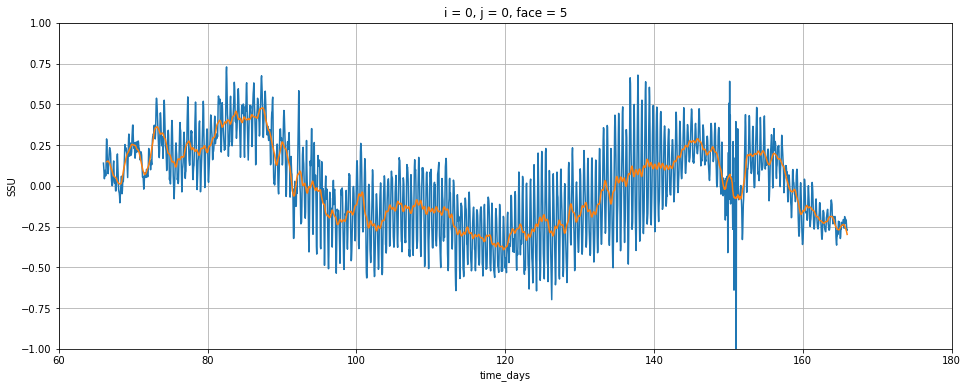

In [11]:
plt.figure(figsize=(16,6))
ax=plt.subplot(111)

toplt =  lds['SSU'].isel(time=slice(0,24*100)).swap_dims({'time': 'time_days'})
toplt.plot(ax=ax)
#
toplt =  res_valid.isel(time=slice(0,24*100)).swap_dims({'time': 'time_days'})
toplt.plot(ax=ax)
#
toplt =  (lds['SSU']-res_valid-2.).isel(time=slice(0,24*100)).swap_dims({'time': 'time_days'})
toplt.plot(ax=ax)

ax.set_xlim(60., 180.)
ax.set_ylim(-1., 1.)
ax.grid()

# the whole domain

In [12]:
lds = ds
wt = lds['SSU'].window
print(wt)

Window []


In [13]:
cutoff = 1.5 # A 1.5-day cutoff
dx = 1./24. # Define the sampling period (one day)
wt.set(n=24*1, dim='time', cutoff=cutoff, dx=dx, window='boxcar')
print(wt)

Window [order->{'time': 24}, cutoff->{'time': 1.5}, dx->{'time': 0.041666666666666664}, window->{'time': 'boxcar'}]


In [14]:
lds_f = wt.convolve(trim=True)
print(lds)

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 5040)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 5
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    time_days  (time) float64 66.0 66.04 66.08 66.12 66.17 66.21 66.25 66.29 ...
Data variables:
    SSU        (i, j, time) float32 dask.array<shape=(4320, 4320, 5040), chunksize=(432, 432, 240)>


Text(0.5,1,'low pass filtered SSU')

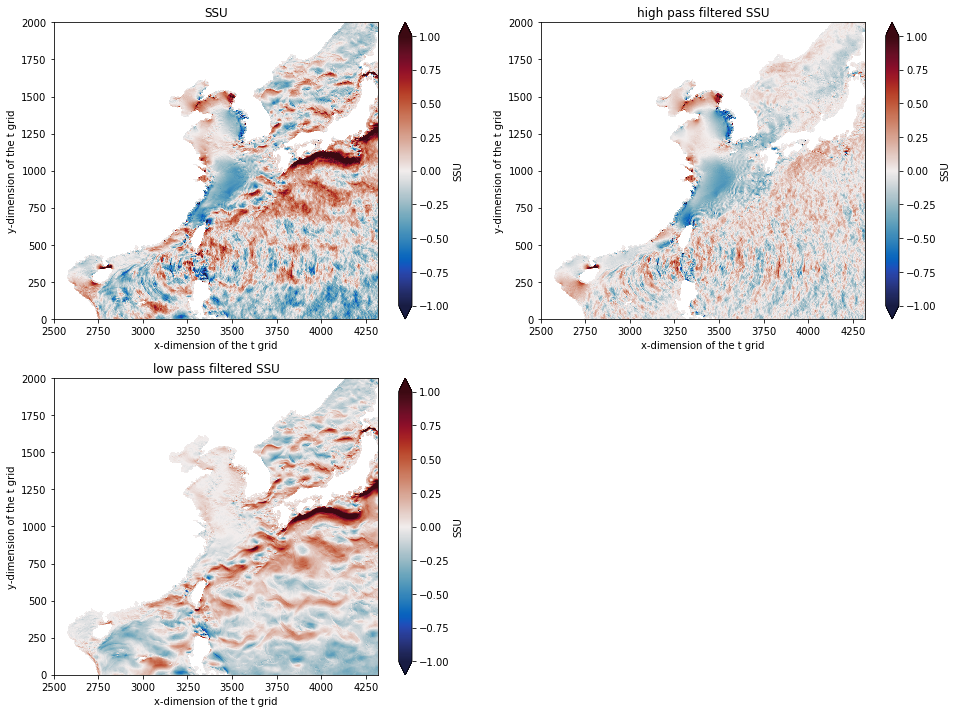

In [15]:
plt.figure(figsize=(16,12))

it=100

eta =  ds['SSU'].isel(time=it, i=slice(2500,4320), j=slice(0,2000)) # 432 file read, because of i chunks
#eta =  lds['Eta'].isel(time=it) # note: xarray open all files in order to load Eta here because of the large chunk along time
eta = eta.persist()

eta_high = (lds['SSU']-lds_f).isel(time=it, i=slice(2500,4320), j=slice(0,2000)) # 1836 file read
eta_high = eta_high.persist()

ax=plt.subplot(221)
eta.plot(ax=ax, x='i', y='j', vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('SSU')

#
ax=plt.subplot(222)
eta_high.plot(ax=ax, x='i', y='j', vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('high pass filtered SSU')

#
ax=plt.subplot(223)
(eta-eta_high).plot(ax=ax, x='i', y='j', vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('low pass filtered SSU')

_____
# Spatial filtering (2d along lat and lon)

In [21]:
ds_10 = ds.isel(time=10)
print(ds_10)

<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 5
    time       float64 5.738e+06
    time_days  float64 66.42
Data variables:
    SSU        (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(432, 432)>


In [22]:
wt = ds_10['SSU'].window
print(wt)

Window []


In [23]:
wt.set(n={'j': 72, 'i': 72}, window={'j':'hanning', 'i':'hanning'})

print(wt)

Window [order->{'j': 72, 'i': 72}, cutoff->{'j': None, 'i': None}, dx->{'j': 1, 'i': 1}, window->{'j': 'hanning', 'i': 'hanning'}]


In [24]:
ds_10_filter = wt.convolve()
print(ds_10_filter)

<xarray.DataArray 'SSU' (i: 4320, j: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(432, 432)>
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 5
    time       float64 5.738e+06
    time_days  float64 66.42


Text(0.5,1,'low pass filtered SSU')

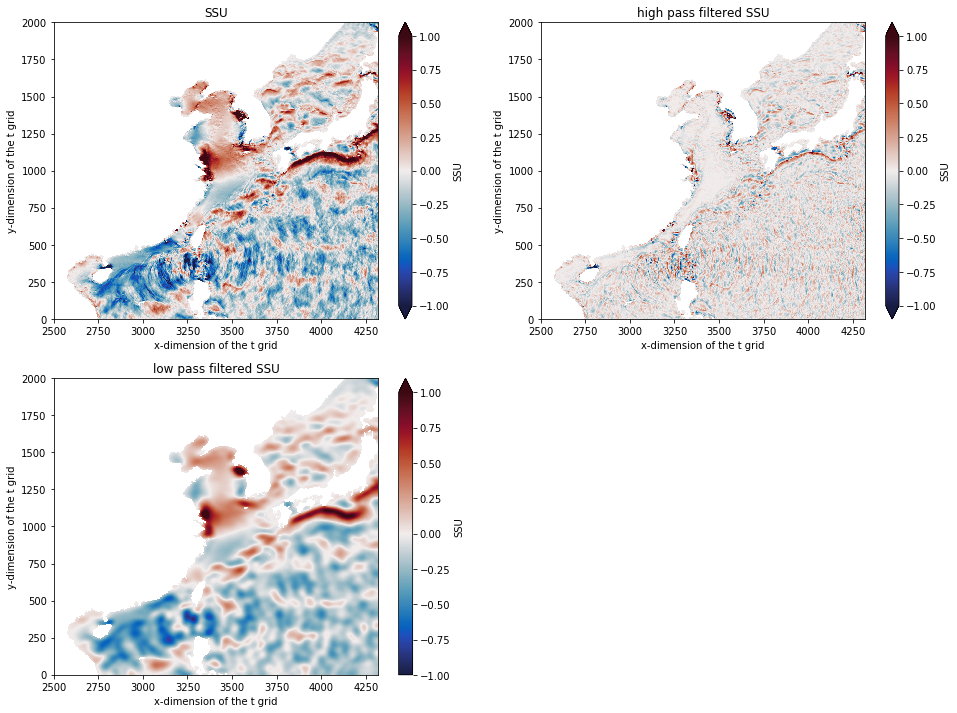

In [25]:
plt.figure(figsize=(16,12))

eta =  ds_10['SSU'].isel(i=slice(2500,4320), j=slice(0,2000)) # 432 file read, because of i chunks
#eta =  lds['Eta'].isel(time=it) # note: xarray open all files in order to load Eta here because of the large chunk along time
eta = eta.persist()

eta_high = (ds_10['SSU']-ds_10_filter).isel(i=slice(2500,4320), j=slice(0,2000)) # 1836 file read
eta_high = eta_high.persist()

ax=plt.subplot(221)
eta.plot(ax=ax, x='i', y='j', vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('SSU')

#
ax=plt.subplot(222)
eta_high.plot(ax=ax, x='i', y='j', vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('high pass filtered SSU')

#
ax=plt.subplot(223)
(eta-eta_high).plot(ax=ax, x='i', y='j', vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('low pass filtered SSU')

In [17]:
client.restart()

Client Scheduler: tcp://10.148.0.221:8786 Dashboard: http://10.148.0.221:8787/status,Cluster Workers: 10 Cores: 140 Memory: 1000.00 GB
